# PS Parallel Programming / Sheet 01
# Fabio Valentini / MN 01018782

## Exercise 1: Amdahl's Law

### Speedup

The speedup factor \\(S(p)\\) is defined as the execution time of the *best* sequential algorithm on a given processor divided by the execution time of a parallel algorithm with a given number of available parallel processors:

\\[ S(p) = \frac{\text{execution time of best sequential algorithm}}{\text{execution time of parallel algorithm on} ~ p ~ \text{processors}} \\]

### Amdahl's Law

\\[ S(p) = \frac{t_s}{f \cdot t_s + (1 - f) \cdot t_s / p} = \frac{p}{1 + (p - 1) \cdot f} \\]

- \$S(p)\$: Speedup \$S(p)\$ depending on the number of parallel processors \$p\$
- \$p\$: number of available parallel processors
- \$t_s\$: time required for running the program serially
- \$f\$: fraction of the program that can not be parallelized

This law describes the speedup that is theoretically possible by running the part of a program that *can* be parallelized in parallel on \\(p\\) processors. It shows that a possible speedup is more strongly dependent on the fraction of the sequential program execution time, because the maximum possible speedup is limited to \\(1 / f\\) for very large \\(p\\), and adding more processors yields only diminishing returns after a certain point. Only optimizing the sequential part of the program can increase the maximal possible speedup:

\\[ \lim_{p\to\infty} S(p) = \frac{1}{f} \\]

### Example 1

- 10% not parallelizable
- 6 cores / \\(\infty\\) cores

In [1]:
p = 6
f = 10 / 100

S_p = p / (1 + (p-1) * f)
print(f"Speedup for {p} cores: {S_p:.2f}")

Speedup for 6 cores: 4.00


In [2]:
p = "infinitely many"
f = 10 / 100

S_max = 1 / f
print(f"Speedup for {p} cores: {S_max:.2f}")

Speedup for infinitely many cores: 10.00


### Example 2

- 20% not parallelizable
- 6 cores / \\( \infty \\) cores

In [3]:
p = 6
f = 20 / 100

S_p = p / (1 + (p-1) * f)
print(f"Speedup for {p} cores: {S_p:.2f}")

Speedup for 6 cores: 3.00


In [4]:
p = "infinitely many"
f = 20 / 100

S_max = 1 / f
print(f"Speedup for {p} cores: {S_max:.2f}")

Speedup for infinitely many cores: 5.00


### Example 3

- \\( \mathcal{O}(n^3) \\) algorithm
- speedup >= 10
- 64 cores

\\[ S_p = \frac{p}{1 + (p - 1) \cdot f} \\]
\\[ \Rightarrow f = \frac{\frac{p}{S_p} - 1}{p - 1} \\]

In [5]:
S_p = 10
p = 64

f = ((p/S_p) - 1) / (p - 1)
print(f"Sequential region of the program can be at most {100*f:.2f}% to achieve speedup {S_p} with {p} cores.")

Sequential region of the program can be at most 8.57% to achieve speedup 10 with 64 cores.


## Exercise 2

### Measure execution times locally

In [6]:
import subprocess
import time

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import parse

%matplotlib inline
set_matplotlib_formats('svg')

parser = parse.Parser("sum: {sum:d}, time: {time:.4f} seconds")

In [7]:
slow = []
medium = []
fast = []

for i in range(1, 17):
    ret = subprocess.run(["./slow"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    slow.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./medium"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    medium.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./fast"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    fast.append(parser.parse(ret.stdout.decode())["time"])

Plot execution times against `OMP_NUM_THREADS`:

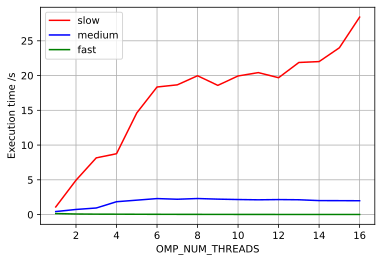

In [8]:
plt.plot(range(1, 17), slow, color="r", label="slow")
plt.plot(range(1, 17), medium, color="b", label="medium")
plt.plot(range(1, 17), fast, color="g", label="fast")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.grid()
plt.legend()
plt.show()

Plot execution times against `OMP_NUM_THREADS` on logarithmic scale:

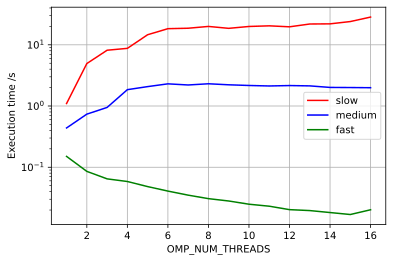

In [9]:
plt.plot(range(1, 17), slow, color="r", label="slow")
plt.plot(range(1, 17), medium, color="b", label="medium")
plt.plot(range(1, 17), fast, color="g", label="fast")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

It seems the "slow" algorithm is really bad at scaling to multiple threads - its execution time grows monotonically when it has access to more threads. I suspect this is because synchronization cost incurred by marking the calculation of `sum` as critical is very high compared to the actual amount of computation.

The "medium" algorithm scales better, but there's probably still a high synchronization cost associated with using atomic integer variable, even if it is more efficient than marking it as "critical".

The "fast" algorithm moves most of the actual calculations out of the "critical" region, and scales really well for more threads.

#### Change optimization flags: `-O2`

In [10]:
slow_o2 = []
medium_o2 = []
fast_o2 = []

for i in range(1, 17):
    ret = subprocess.run(["./slow-O2"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    slow_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./medium-O2"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    medium_o2.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./fast-O2"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    fast_o2.append(parser.parse(ret.stdout.decode())["time"])

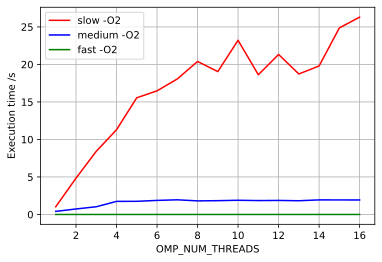

In [11]:
plt.plot(range(1, 17), slow_o2, color="r", label="slow -O2")
plt.plot(range(1, 17), medium_o2, color="b", label="medium -O2")
plt.plot(range(1, 17), fast_o2, color="g", label="fast -O2")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.grid()
plt.legend()
plt.show()

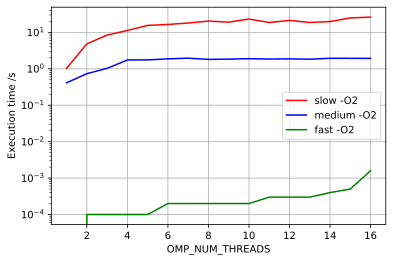

In [12]:
plt.plot(range(1, 17), slow_o2, color="r", label="slow -O2")
plt.plot(range(1, 17), medium_o2, color="b", label="medium -O2")
plt.plot(range(1, 17), fast_o2, color="g", label="fast -O2")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

#### Change optimization flags: `-O3`

In [13]:
slow_o3 = []
medium_o3 = []
fast_o3 = []

for i in range(1, 17):
    ret = subprocess.run(["./slow-O3"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    slow_o3.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./medium-O3"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    medium_o3.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(["./fast-O3"], env={"OMP_NUM_THREADS": str(i)}, stdout=subprocess.PIPE)
    fast_o3.append(parser.parse(ret.stdout.decode())["time"])

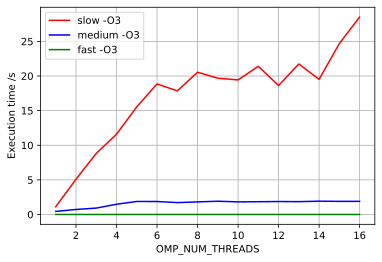

In [14]:
plt.plot(range(1, 17), slow_o3, color="r", label="slow -O3")
plt.plot(range(1, 17), medium_o3, color="b", label="medium -O3")
plt.plot(range(1, 17), fast_o3, color="g", label="fast -O3")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.grid()
plt.legend()
plt.show()

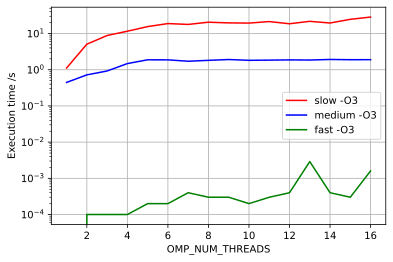

In [15]:
plt.plot(range(1, 17), slow_o3, color="r", label="slow -O3")
plt.plot(range(1, 17), medium_o3, color="b", label="medium -O3")
plt.plot(range(1, 17), fast_o3, color="g", label="fast -O3")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

#### Compare no optimizations with `-O2` and `-O3`

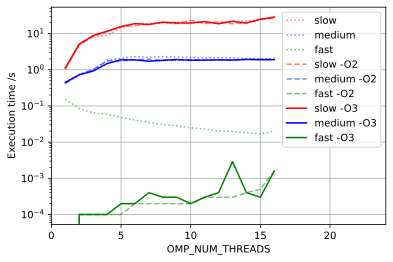

In [16]:
plt.plot(range(1, 17), slow, color="r", label="slow", linestyle="dotted", alpha=0.5)
plt.plot(range(1, 17), medium, color="b", label="medium", linestyle="dotted", alpha=0.5)
plt.plot(range(1, 17), fast, color="g", label="fast", linestyle="dotted", alpha=0.5)

plt.plot(range(1, 17), slow_o2, color="r", label="slow -O2", linestyle="dashed", alpha=0.5)
plt.plot(range(1, 17), medium_o2, color="b", label="medium -O2", linestyle="dashed", alpha=0.5)
plt.plot(range(1, 17), fast_o2, color="g", label="fast -O2", linestyle="dashed", alpha=0.5)

plt.plot(range(1, 17), slow_o3, color="r", label="slow -O3")
plt.plot(range(1, 17), medium_o3, color="b", label="medium -O3")
plt.plot(range(1, 17), fast_o3, color="g", label="fast -O3")

plt.xlim(0, 24)
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

#### Data in tabular format

In [17]:
import numpy as np
import pandas as pd

data = [
    [*range(1, 17)],
    slow, medium, fast,
    slow_o2, medium_o2, fast_o2,
    slow_o3, medium_o3, fast_o3,
]

df = pd.DataFrame(
    np.transpose(data),
    columns=[
        "OMP_NUM_THREADS",
        "slow", "medium", "fast",
        "slow -O2", "medium -O2", "fast -O2",
        "slow -O3", "medium -O3", "fast -O3",
    ]
)

from IPython.display import HTML
HTML(df.to_html(index=False))

OMP_NUM_THREADS,slow,medium,fast,slow -O2,medium -O2,fast -O2,slow -O3,medium -O3,fast -O3
1.0,1.0990,0.4384,0.1504,1.0289,0.4125,0.0000,1.1126,0.4461,0.0000
2.0,4.9434,0.7375,0.0856,4.8414,0.7342,0.0001,5.0861,0.7213,0.0001
3.0,8.1596,0.9486,0.0646,8.4166,1.0296,0.0001,8.8203,0.9238,0.0001
4.0,8.7551,1.8513,0.0585,11.2971,1.7447,0.0001,11.5974,1.4790,0.0001
5.0,14.6218,2.0764,0.0483,15.5585,1.7544,0.0001,15.5402,1.8797,0.0002
6.0,18.3507,2.3039,0.0408,16.4831,1.8754,0.0002,18.8511,1.8733,0.0002
7.0,18.6612,2.2077,0.0350,18.0646,1.9542,0.0002,17.8472,1.7165,0.0004
8.0,19.9694,2.3104,0.0307,20.3941,1.8130,0.0002,20.5468,1.8168,0.0003
9.0,18.5847,2.2228,0.0281,19.0430,1.8401,0.0002,19.6771,1.9144,0.0003
10.0,19.9408,2.1663,0.0249,23.2177,1.8944,0.0002,19.4353,1.8203,0.0002


Looking at this data, compiler optimizations do not meaningfully affect the "slow" or "medium" algorithms, where the execution time is almost unaffected. For the "fast" algorithm, compiler optimizations (either `-O2` or `-O3` improve performance by almost a factor of 1000, but the speedup is biggest for the smallest number of available threads.

I suspect that with the more optimized code, synchronization again becomes a bottleneck. The fastest measured execution times were obtained for the "fast" algorithm with `-O2` and `-O3` compiler optimizations on *one* available thread. Values were below 0.1 ms, so they were printed as "0.0000" due to the limit of 4 decimal points in the C code (which is why the "fast -O2" and "fast -O3" data points for one thread don't show up in the plots with logarithmic scale).

The measurements also tended to be quite stable when running the programs multiple times. The only meaningful deviations occurred when other programs were using CPU resources at the same time.

## Hardware + Software

- CPU: AMD Ryzen 7 1700X (8 Cores, 16 Threads)
- OS: Fedora Workstation 33
- Compiler: `gcc (GCC) 10.2.1 20201125 (Red Hat 10.2.1-9)`
- Report: Python 3.9.2, Jupyter Notebook 6.0.3, IPython 7.18.1, ipykernel 5.2.1, matplotlib 3.3.4, pandas 1.0.5